# Set evironment on colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install catboost

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 14.8 MB/s eta 0:00:00


# Import

In [ ]:
import warnings

warnings.filterwarnings("ignore")

import os
import gc
import datetime


import numpy as np
import pandas as pd
import polars as pl
import pyarrow as pa
import seaborn as sns
import matplotlib.pyplot as plt

import joblib
import catboost as cb


import holidays

# Class

## load data

In [ ]:
class DataStorage:
    # root = "..\data"
    root = "/content/drive/MyDrive/predict-energy-behavior-of-prosumers/Data"

    data_cols = [
        "target",
        "county",
        "is_business",
        "product_type",
        "is_consumption",
        "datetime",
        "row_id",
    ]
    client_cols = [
        "product_type",
        "county",
        "eic_count",
        "installed_capacity",
        "is_business",
        "date",
    ]
    gas_prices_cols = ["forecast_date", "lowest_price_per_mwh", "highest_price_per_mwh"]
    electricity_prices_cols = ["forecast_date", "euros_per_mwh"]
    forecast_weather_cols = [
        "latitude",
        "longitude",
        "origin_datetime",
        "hours_ahead",
        "temperature",
        "dewpoint",
        "cloudcover_high",
        "cloudcover_low",
        "cloudcover_mid",
        "cloudcover_total",
        "10_metre_u_wind_component",
        "10_metre_v_wind_component",
        "forecast_datetime",
        "direct_solar_radiation",
        "surface_solar_radiation_downwards",
        "snowfall",
        "total_precipitation",
    ]
    historical_weather_cols = [
        "datetime",
        "temperature",
        "dewpoint",
        "rain",
        "snowfall",
        "surface_pressure",
        "cloudcover_total",
        "cloudcover_low",
        "cloudcover_mid",
        "cloudcover_high",
        "windspeed_10m",
        "winddirection_10m",
        "shortwave_radiation",
        "direct_solar_radiation",
        "diffuse_radiation",
        "latitude",
        "longitude",
    ]
    location_cols = ["longitude", "latitude", "county"]
    target_cols = [
        "target",
        "county",
        "is_business",
        "product_type",
        "is_consumption",
        "datetime",
    ]

    def __init__(self):
        self.df_data = pl.read_csv(
            os.path.join(self.root, "train.csv"),
            columns=self.data_cols,
            try_parse_dates=True,
        )
        self.df_client = pl.read_csv(
            os.path.join(self.root, "client.csv"),
            columns=self.client_cols,
            try_parse_dates=True,
        )
        self.df_gas_prices = pl.read_csv(
            os.path.join(self.root, "gas_prices.csv"),
            columns=self.gas_prices_cols,
            try_parse_dates=True,
        )
        self.df_electricity_prices = pl.read_csv(
            os.path.join(self.root, "electricity_prices.csv"),
            columns=self.electricity_prices_cols,
            try_parse_dates=True,
        )
        self.df_forecast_weather = pl.read_csv(
            os.path.join(self.root, "forecast_weather.csv"),
            columns=self.forecast_weather_cols,
            try_parse_dates=True,
        )
        self.df_historical_weather = pl.read_csv(
            os.path.join(self.root, "historical_weather.csv"),
            columns=self.historical_weather_cols,
            try_parse_dates=True,
        )
        self.df_weather_station_to_county_mapping = pl.read_csv(
            os.path.join(self.root, "weather_station_to_county_mapping.csv"),
            columns=self.location_cols,
            try_parse_dates=True,
        )
        self.df_data = self.df_data.filter(
            (pl.col("datetime") >= pd.to_datetime("2022-01-01"))
        )
        self.df_target = self.df_data.select(self.target_cols)

        self.df_weather_station_to_county_mapping = (
            self.df_weather_station_to_county_mapping.with_columns(
                pl.col("latitude").cast(pl.datatypes.Float32),
                pl.col("longitude").cast(pl.datatypes.Float32),
            )
        )




## Feature Enegineering

In [ ]:
class FeaturesGenerator:
    def __init__(self, data_storage):
        self.data_storage = data_storage
        self.estonian_holidays = list(
            holidays.country_holidays("EE", years=range(2021, 2026)).keys()
        )
    
    
    def _add_general_features(self, df_features):
        #basic time features
        df_features = (
            df_features.with_columns(
                pl.col("datetime").dt.ordinal_day().alias("dayofyear"),
                pl.col("datetime").dt.hour().alias("hour"),
                pl.col("datetime").dt.day().alias("day"),
                pl.col("datetime").dt.week().alias("week"),
                pl.col("datetime").dt.weekday().alias("weekday"),
                pl.col("datetime").dt.month().alias("month"),
                pl.col("datetime").dt.quarter().alias("quarter"),
                pl.col("datetime").dt.year().alias("year"),
                )
        #Tag different types of prosumers in different regions as id for this category.
            .with_columns(
                pl.concat_str(
                    "county",
                    "is_business",
                    "product_type",
                    "is_consumption",
                    separator="_",
                ).alias("segment"),
            )
        # cyclical features encoding (refrence:https://towardsdatascience.com/cyclical-features-encoding-its-about-time-ce23581845ca)
            .with_columns(
                (np.pi * pl.col("dayofyear") / 183).sin().alias("sin(dayofyear)"),
                (np.pi * pl.col("dayofyear") / 183).cos().alias("cos(dayofyear)"),
                (np.pi * pl.col("hour") / 12).sin().alias("sin(hour)"),
                (np.pi * pl.col("hour") / 12).cos().alias("cos(hour)"),
            )
        )
        return df_features
    
    def is_country_holiday(self, row):
        return (
            datetime.date(row["year"], row["month"], row["day"])
            in self.estonian_holidays
        )

    def _add_holidays_features(self, df_features):
        df_features = df_features.with_columns(
            pl.struct(["year", "month", "day"])
            .apply(self.is_country_holiday)
            .alias("is_country_holiday")
        )
        return df_features


    def _add_client_features(self, df_features):
        df_client = self.data_storage.df_client
        #Only client information from two days ago is available for each prediction.
        df_features = df_features.join(
            df_client.with_columns(
                (pl.col("date") + pl.duration(days=2)).cast(pl.Date)
            ),
            on=["county", "is_business", "product_type", "date"],
            how="left",
        )
        return df_features

    
    def _add_forecast_weather_features(self, df_features):
        df_forecast_weather = self.data_storage.df_forecast_weather
        df_weather_station_to_county_mapping = (
            self.data_storage.df_weather_station_to_county_mapping
        )
        
        df_forecast_weather = (
            df_forecast_weather.rename({"forecast_datetime": "datetime"})
            .filter((pl.col("hours_ahead") >= 22) & pl.col("hours_ahead") <= 45)
            .drop("hours_ahead")
            .with_columns(
                pl.col("latitude").cast(pl.datatypes.Float32),
                pl.col("longitude").cast(pl.datatypes.Float32),
            )
            .join(
                df_weather_station_to_county_mapping,
                how="left",
                on=["longitude", "latitude"],
            )
            .drop("longitude", "latitude", "origin_datetime")
        )

        df_forecast_weather_date = (
            df_forecast_weather.group_by("datetime").mean().drop("county")
        )

        df_forecast_weather_local = (
            df_forecast_weather.filter(pl.col("county").is_not_null())
            .group_by("county", "datetime")
            .mean()
        )
        #Uses the current information of the weather forecast, and the simultaneous moment-in-time weather forecast information from a week ago.
        for hours_lag in [0, 7 * 24]:
            df_features = df_features.join(
                df_forecast_weather_date.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ),
                on="datetime",
                how="left",
                suffix=f"_forecast_{hours_lag}h",
            )
            df_features = df_features.join(
                df_forecast_weather_local.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ),
                on=["county", "datetime"],
                how="left",
                suffix=f"_forecast_local_{hours_lag}h",
            )
        #Calculation of the rate of change of weather forecast information compared to the same time one week ago
        df_features = df_features.with_columns(
            (
                pl.col(f"temperature_forecast_local_0h")
                / (pl.col(f"temperature_forecast_local_168h") + 1e-3)
            ).alias(f"temperature_forecast_local_0h/168h"),
            (
                pl.col(f"surface_solar_radiation_downwards_forecast_local_0h")
                / (pl.col(f"surface_solar_radiation_downwards_forecast_local_168h") + 1e-3)
            ).alias(f"surface_solar_radiation_downwards_forecast_local_0h/168h"),
        )

        return df_features

    def _add_historical_weather_features(self, df_features):
        df_historical_weather = self.data_storage.df_historical_weather
        df_weather_station_to_county_mapping = (
            self.data_storage.df_weather_station_to_county_mapping
        )

        df_historical_weather = (
            df_historical_weather.with_columns(
                pl.col("latitude").cast(pl.datatypes.Float32),
                pl.col("longitude").cast(pl.datatypes.Float32),
            )
            .join(
                df_weather_station_to_county_mapping,
                how="left",
                on=["longitude", "latitude"],
            )
            .drop("longitude", "latitude")
        )

        df_historical_weather_date = (
            df_historical_weather.group_by("datetime").mean().drop("county")
        )

        df_historical_weather_local = (
            df_historical_weather.filter(pl.col("county").is_not_null())
            .group_by("county", "datetime")
            .mean()
        )
        
        #Using historical weather data from the same point in time two days ago and one week ago
        for hours_lag in [2 * 24, 7 * 24]:
            df_features = df_features.join(
                df_historical_weather_date.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ),
                on="datetime",
                how="left",
                suffix=f"_historical_{hours_lag}h",
            )
            df_features = df_features.join(
                df_historical_weather_local.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ),
                on=["county", "datetime"],
                how="left",
                suffix=f"_historical_local_{hours_lag}h",
            )
        #Use historical weather data up to 11 a.m. one day prior (historical weather data is updated daily at 11 a.m.)
        for hours_lag in [1 * 24]:
            df_features = df_features.join(
                df_historical_weather_date.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag),
                    pl.col("datetime").dt.hour().alias("hour"),
                )
                .filter(pl.col("hour") <= 10)
                .drop("hour"),
                on="datetime",
                how="left",
                suffix=f"_historical_{hours_lag}h",
            )
        #Calculation of the rate of change of historical weather information at the same time two days ago compared to the same time one week ago
        df_features = df_features.with_columns(
            (
                pl.col(f"temperature_historical_local_48h")
                / (pl.col(f"temperature_historical_local_168h") + 1e-3)
            ).alias(f"temperature_historical_local_48h/168h"),
            (
                pl.col(f"direct_solar_radiation_historical_local_48h")
                / (pl.col(f"direct_solar_radiation_historical_local_168h") + 1e-3)
            ).alias(f"direct_solar_radiation_historical_local_48h/168h"),
        #Calculation of the rate of change of historical weather information(0 - 10 am) at the same time one day ago compared to the same time two days ago
            (
                pl.col(f"temperature_historical_24h")
                / (pl.col(f"temperature") + 1e-3)
            ).alias(f"temperature_historical_24h/48h"),
            (
                pl.col(f"direct_solar_radiation_historical_24h")
                / (pl.col(f"direct_solar_radiation") + 1e-3)
            ).alias(f"direct_solar_radiation_historical_24h/48h"),

        )

        return df_features

    def _add_target_features(self, df_features):
        df_target = self.data_storage.df_target
        #Target values for different product_types
        df_target_all_type_sum = (
            df_target.group_by(["datetime", "county", "is_business", "is_consumption"])
            .sum()
            .drop("product_type")
        )
        #Target values for different counties and product_types
        df_target_all_county_type_sum = (
            df_target.group_by(["datetime", "is_business", "is_consumption"])
            .sum()
            .drop("product_type", "county")
        )

        #Target value at the same moment in the last 2-14 days
        hours_list=[i*24 for i in range(2,15)]

        for hours_lag in hours_list:
            df_features = df_features.join(
                df_target.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ).rename({"target": f"target_{hours_lag}h"}),
                on=[
                    "county",
                    "is_business",
                    "product_type",
                    "is_consumption",
                    "datetime",
                ],
                how="left",
            )
        
        for hours_lag in [2 * 24, 3 * 24, 7 * 24, 14 * 24]:
            df_features = df_features.join(
            #Total value of target for the same product_type at the same time in the last 2, 3, 7 and 14 days.
            df_target_all_type_sum.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ).rename({"target": f"target_all_type_sum_{hours_lag}h"}),
                on=["county", "is_business", "is_consumption", "datetime"],
                how="left",
            )
            #Total value of target for the same product_type and county at the same time in the last 2, 3, 7 and 14 days.
            df_features = df_features.join(
                df_target_all_county_type_sum.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ).rename({"target": f"target_all_county_type_sum_{hours_lag}h"}),
                on=["is_business", "is_consumption", "datetime"],
                how="left",
                suffix=f"_all_county_type_sum_{hours_lag}h",
            )
        
        #Mean and standard deviation of target values at the same point in a week
        cols_for_stats = [
            f"target_{hours_lag}h" for hours_lag in [2 * 24, 3 * 24, 4 * 24, 5 * 24, 6 * 24, 7 *24]
        ]
        df_features = df_features.with_columns(
            df_features.select(cols_for_stats).mean(axis=1).alias(f"target_mean"),
            df_features.select(cols_for_stats)
            .transpose()
            .std()
            .transpose()
            .to_series()
            .alias(f"target_std"),
        )
        #Rate of change in target value for different combinations over a two-week period
        for target_prefix, lag_nominator, lag_denomonator in [
            ("target", 24 * 7, 24 * 14),
            ("target", 24 * 2, 24 * 9),
            ("target", 24 * 3, 24 * 10),
            ("target", 24 * 2, 24 * 3),
            ("target_all_type_sum", 24 * 2, 24 * 3),
            ("target_all_type_sum", 24 * 7, 24 * 14),
            ("target_all_county_type_sum", 24 * 2, 24 * 3),
            ("target_all_county_type_sum", 24 * 7, 24 * 14),
        ]:
            df_features = df_features.with_columns(
                (
                    pl.col(f"{target_prefix}_{lag_nominator}h")
                    / (pl.col(f"{target_prefix}_{lag_denomonator}h") + 1e-3)
                ).alias(f"{target_prefix}_ratio_{lag_nominator}_{lag_denomonator}")
            )

        return df_features
    
    #The amount of change (difference) in meteorological data from 1h ago, 3h ago, and 24 ago.
    def _additional_features(self,df_features):
        for col in [
                    'temperature',
                    'dewpoint',
                    '10_metre_u_wind_component',
                    '10_metre_v_wind_component',
                    "cloudcover_total",
                    "cloudcover_low",
                    "cloudcover_mid",
                    "cloudcover_high",
                    "windspeed_10m",
                    "winddirection_10m",
                    "shortwave_radiation",
                    "direct_solar_radiation",
                    "diffuse_radiation",
            ]:
            for window in [1,3,24]:
                df_features[f"{col}_diff_{window}"] = df_features.groupby(["county", 'is_consumption', 'product_type', 'is_business'])[col].diff(window)
        return df_features


    def _add_gas_prices_features(self, df_features):
        df_gas_prices = self.data_storage.df_gas_prices

        df_features = df_features.join(df_gas_prices.rename(
                                    {"forecast_date": "date"})
                                    .with_columns(
                                        (pl.col("date") + pl.duration(days=1)).cast(pl.Date)
                                    ),
                                    on= "date",
                                    how="left")

        return df_features

    def _add_electricity_prices_features(self, df_features):
        df_electricity_prices = self.data_storage.df_electricity_prices

        df_features = df_features.join(df_electricity_prices.rename(
                                    {"forecast_date": "datetime"})
                                    .with_columns(
                                        pl.col("datetime")+ pl.duration(hours=24)
                                    ),
                                    on="datetime" ,
                                    how="left")

        return df_features


    def _reduce_memory_usage(self, df_features):
        df_features = df_features.with_columns(pl.col(pl.Float64).cast(pl.Float32))
        return df_features
    
    #Drop columns that are not needed for modelling Because these features are so sparse.
    def _drop_columns(self, df_features):
        df_features = df_features.drop(
            "date", "dayofyear"
        )
        return df_features
    
    def _to_pandas(self, df_features, y):
        '''Because the format of the category features is required to be "categroy" when training with lightgbm later, 
           the table needs to be converted to a pandas dataframe.
        '''
        cat_cols = [
            "county",
            "is_business",
            "product_type",
            "is_consumption",
            "segment",
            "quarter",
        ]

        if y is not None:
            df_features = pd.concat([df_features.to_pandas(), y.to_pandas()], axis=1)
        else:
            df_features = df_features.to_pandas()

        df_features[cat_cols] = df_features[cat_cols].astype("category")

        for i in ['row_id','year','date']:
            if i in df_features.columns:
                df_features = df_features.drop(i, axis=1)


        return df_features

    def generate_features(self, df_prediction_items):
        if "target" in df_prediction_items.columns:
            df_prediction_items, y = (
                df_prediction_items.drop("target"),
                df_prediction_items.select("target"),
            )
        else:
            y = None

        df_features = df_prediction_items.with_columns(
            pl.col("datetime").cast(pl.Date).alias("date"),
        )

        for add_features in [
            self._add_general_features,
            self._add_holidays_features,
            self._add_client_features,
            self._add_forecast_weather_features,
            self._add_historical_weather_features,
            self._add_target_features,
            self._add_gas_prices_features,
            self._add_electricity_prices_features,
            self._reduce_memory_usage,
            self._drop_columns,
        ]:
            df_features = add_features(df_features)

        df_features = self._to_pandas(df_features, y)
        df_features = self._additional_features(df_features)
        return df_features

## Model

In [ ]:
class Model:
    def __init__(self):
        self.name = "catboost"
        self.target_diff = "target_48h"

        self.cat_features = ["county", "is_business", "product_type", "is_consumption", "segment", "quarter"]
        self.model_parameters_consumption = {
        "random_seed":49,
        "loss_function":"RMSE",
        "task_type":"GPU",
        'bootstrap_type': 'Bernoulli',
        "silent":True,

		'iterations': 9500,
		'learning_rate': 0.0369884033597276,
		'depth': 8,
		'random_strength': 10.157424726456316,
		'subsample': 0.9,
		'min_data_in_leaf': 768,
		'reg_lambda': 40.721327967009245,
        }

        self.model_parameters_production = {
        "random_seed":49,
        "loss_function":"RMSE",
        "task_type":"GPU",
        'bootstrap_type': 'Bernoulli',
        "silent":True,


		'iterations': 6500,
		'learning_rate': 0.019811896659577364,
		'depth': 8,
		'random_strength': 14.740821849341899,
		'subsample': 1.0,
		'min_data_in_leaf': 766,
		'reg_lambda': 49.31291264495959,
        }

        self.model_parameters_consumption_diff = {
        "random_seed":49,
        "loss_function":"RMSE",
        "task_type":"GPU",
        'bootstrap_type': 'Bernoulli',
        "silent":True,

        'iterations': 10000,
		'learning_rate': 0.0435800174329228,
		'depth': 9,
		'random_strength': 32.94004287589372,
		'subsample': 1.0,
		'min_data_in_leaf': 688,
		'reg_lambda': 7.974249285549815,
        }

        self.model_parameters_production_diff = {
        "random_seed":49,
        "loss_function":"RMSE",
        "task_type":"GPU",
        'bootstrap_type': 'Bernoulli',
        "silent":True,

		'iterations': 7000,
		'learning_rate': 0.02891697060314784,
		'depth': 9,
		'random_strength': 39.11590475003397,
		'subsample': 0.9,
		'min_data_in_leaf': 610,
		'reg_lambda': 15.1511098243293,
        }

        self.model_consumption = cb.CatBoostRegressor(**self.model_parameters_consumption, cat_features=self.cat_features)
        self.model_consumption_diff = cb.CatBoostRegressor(**self.model_parameters_consumption_diff, cat_features=self.cat_features)
        self.model_production = cb.CatBoostRegressor(**self.model_parameters_production, cat_features=self.cat_features)
        self.model_production_diff = cb.CatBoostRegressor(**self.model_parameters_production_diff, cat_features=self.cat_features)

    def fit(self, df_train_features):
        mask = df_train_features["is_consumption"] == 1
        self.model_consumption.fit(
            X=df_train_features[mask].drop(columns=["target"]),
            y=df_train_features[mask]["target"],
        )
        self.model_consumption_diff.fit(
            X=df_train_features[mask].drop(columns=["target"]),
            y=df_train_features[mask]["target"]
            - df_train_features[mask][self.target_diff].fillna(0),
        )

        mask = df_train_features["is_consumption"] == 0
        self.model_production.fit(
            X=df_train_features[mask].drop(columns=["target"]),
            y=df_train_features[mask]["target"],
        )
        self.model_production_diff.fit(
            X=df_train_features[mask].drop(columns=["target"]),
            y=df_train_features[mask]["target"]
            - df_train_features[mask][self.target_diff].fillna(0),
        )


    def save(self):
        #local
        # joblib.dump(self.model_consumption, os.path.join( "..\Model", "model_consumption_catboost.pkl"))
        # joblib.dump(self.model_production, os.path.join( "..\Model", "model_production_catboost.pkl"))
        # joblib.dump(self.model_consumption_diff, os.path.join( "..\Model", "model_consumption_diff_catboost.pkl"))
        # joblib.dump(self.model_production_diff, os.path.join( "..\Model", "model_production_diff_catboost.pkl"))

        #colab
        joblib.dump(self.model_consumption, os.path.join( "/content/drive/MyDrive/Model", "model_consumption_catboost.pkl"))
        joblib.dump(self.model_production, os.path.join( "/content/drive/MyDrive/Model", "model_production_catboost.pkl"))
        joblib.dump(self.model_consumption_diff, os.path.join( "/content/drive/MyDrive/Model", "model_consumption_diff_catboost.pkl"))
        joblib.dump(self.model_production_diff, os.path.join( "/content/drive/MyDrive/Model", "model_production_diff_catboost.pkl"))


    def load(self):
        self.model_consumption = joblib.load(os.path.join( "..\Model", "model_consumption_catboost.pkl"))
        self.model_production = joblib.load(os.path.join( "..\Model", "model_production_catboost.pkl"))
        self.model_consumption_diff = joblib.load(os.path.join( "..\Model", "model_consumption_diff_catboost.pkl"))
        self.model_production_diff = joblib.load(os.path.join( "..\Model", "model_production_diff_catboost.pkl"))

    def predict(self, df_features):
        predictions = np.zeros(len(df_features))

        mask = df_features["is_consumption"] == 1
        predictions[mask.values] = np.clip(
            self.model_consumption.predict(df_features[mask]) * 0.5
            + (
                df_features[mask][self.target_diff].fillna(0).values
                + self.model_consumption_diff.predict(df_features[mask])
            )
            * 0.5,
            0,
            np.inf,
        )

        mask = df_features["is_consumption"] == 0
        predictions[mask.values] = np.clip(
            self.model_production.predict(df_features[mask]) * 0.5
            + (
                df_features[mask][self.target_diff].fillna(0).values
                + self.model_production_diff.predict(df_features[mask])
            )
            * 0.5,
            0,
            np.inf,
        )

        return predictions

# Initialisation

In [ ]:
data_storage = DataStorage()
features_generator = FeaturesGenerator(data_storage=data_storage)
target_cols = [
        "target",
        "county",
        "is_business",
        "product_type",
        "is_consumption",
        "datetime",
    ]
cat_cols = ["county",
        "is_business",
        "product_type",
        "is_consumption",
    ]

# Training and validation set split

In [ ]:
df_features = features_generator.generate_features(data_storage.df_data)
df_features = df_features[df_features['target'].notnull()]

df_train_features = df_features[df_features['datetime'] <= pd.to_datetime("2023-05-17")]
df_test = df_features[df_features['datetime'] > pd.to_datetime("2023-05-17")]

df_test_target = df_test[target_cols].rename(columns={"target":"real_target"})
df_test_target[cat_cols] = df_test_target[cat_cols].astype("int")
df_test_features = df_test.copy().drop(columns=["target",'datetime'])

df_train_features = df_train_features.drop(columns=["datetime"])
df_train_features.shape

(1604324, 216)

# Model training

In [ ]:
model = Model()
model.fit(df_train_features)
model.save()
# model.load()

# Validation

In [ ]:
def calculate_validation_score(model):
        df_predictions = df_test_target.copy()

        df_predictions["target"] = model.predict(df_test_features)

        df_predictions["score"] = np.abs(
            df_predictions["target"] - df_predictions["real_target"]
            )

        assert (
            df_predictions[df_predictions["real_target"].notnull()]["score"]
            .isnull()
            .mean()
            == 0
        )

        data_predictions_each_datetime_mean_consumption =  df_predictions[df_predictions["is_consumption"] == 1].groupby("datetime").mean()
        wide_df1 = pd.DataFrame(data_predictions_each_datetime_mean_consumption,
                                data_predictions_each_datetime_mean_consumption.index, ["target", "real_target"])

        data_predictions_each_datetime_mean_production =  df_predictions[df_predictions["is_consumption"] == 0].groupby("datetime").mean()
        wide_df0 = pd.DataFrame(data_predictions_each_datetime_mean_production,
                                data_predictions_each_datetime_mean_production.index, ["target", "real_target"])

        plt.figure(figsize=(20, 10))
        sns.lineplot(data=wide_df1)
        plt.title("Mean_Consumption_all_prosumers")
        plt.show()
        plt.figure(figsize=(20, 10))
        plt.title("Mean_Production_all_prosumers")
        sns.lineplot(data=wide_df0)
        plt.show()

        if hasattr(model, "name"):
            model_name = model.name
        else:
            model_name = model.__class__.__name__

        gc.collect()
        return {"model_name": model_name, "MAE": df_predictions["score"].mean()}

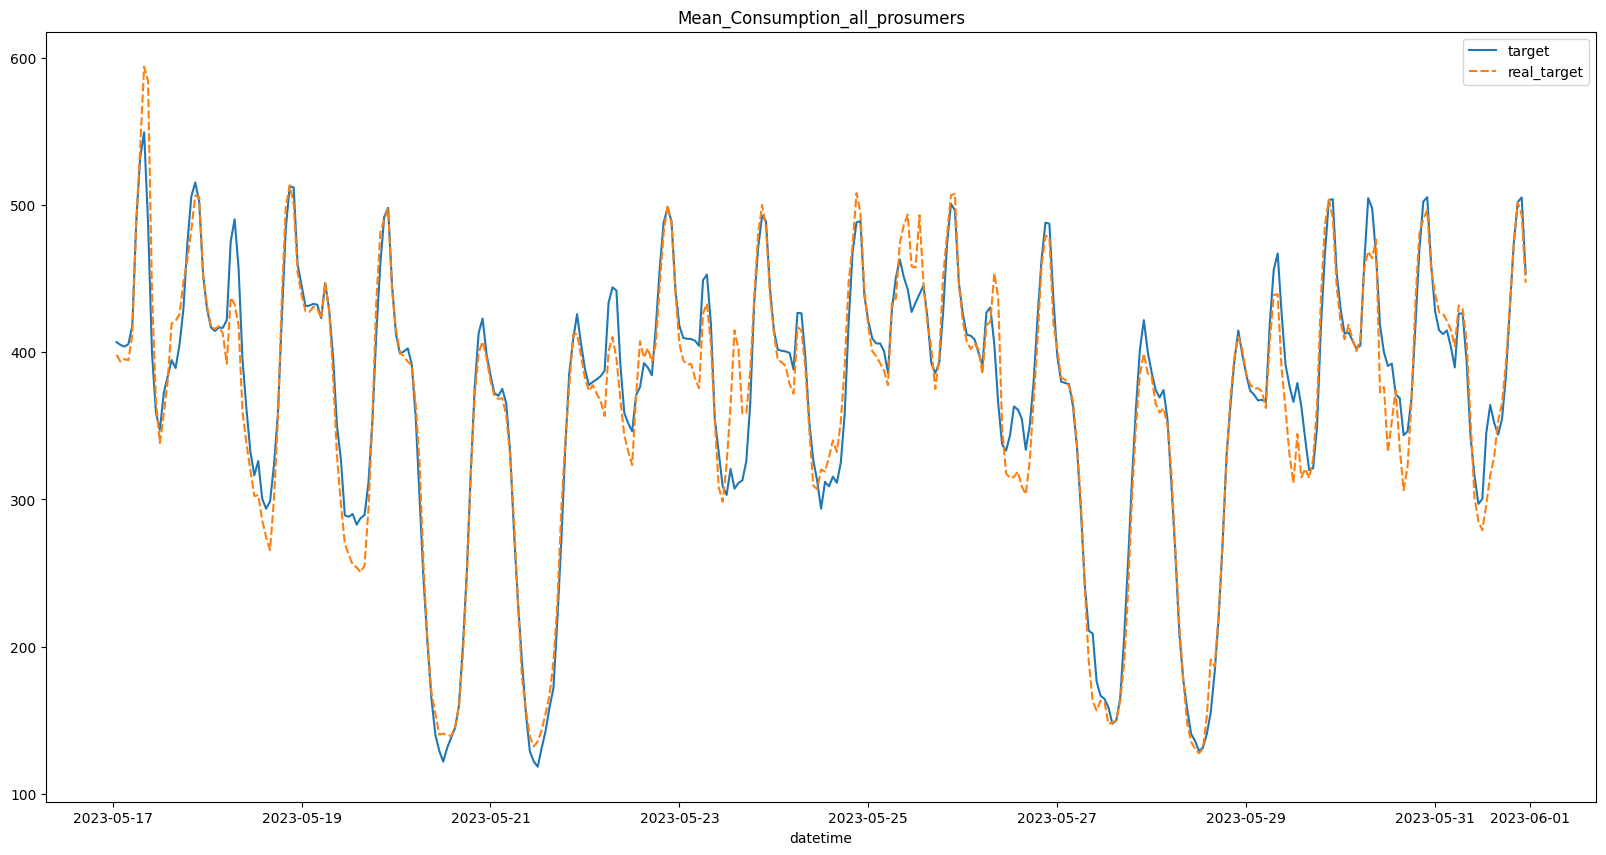

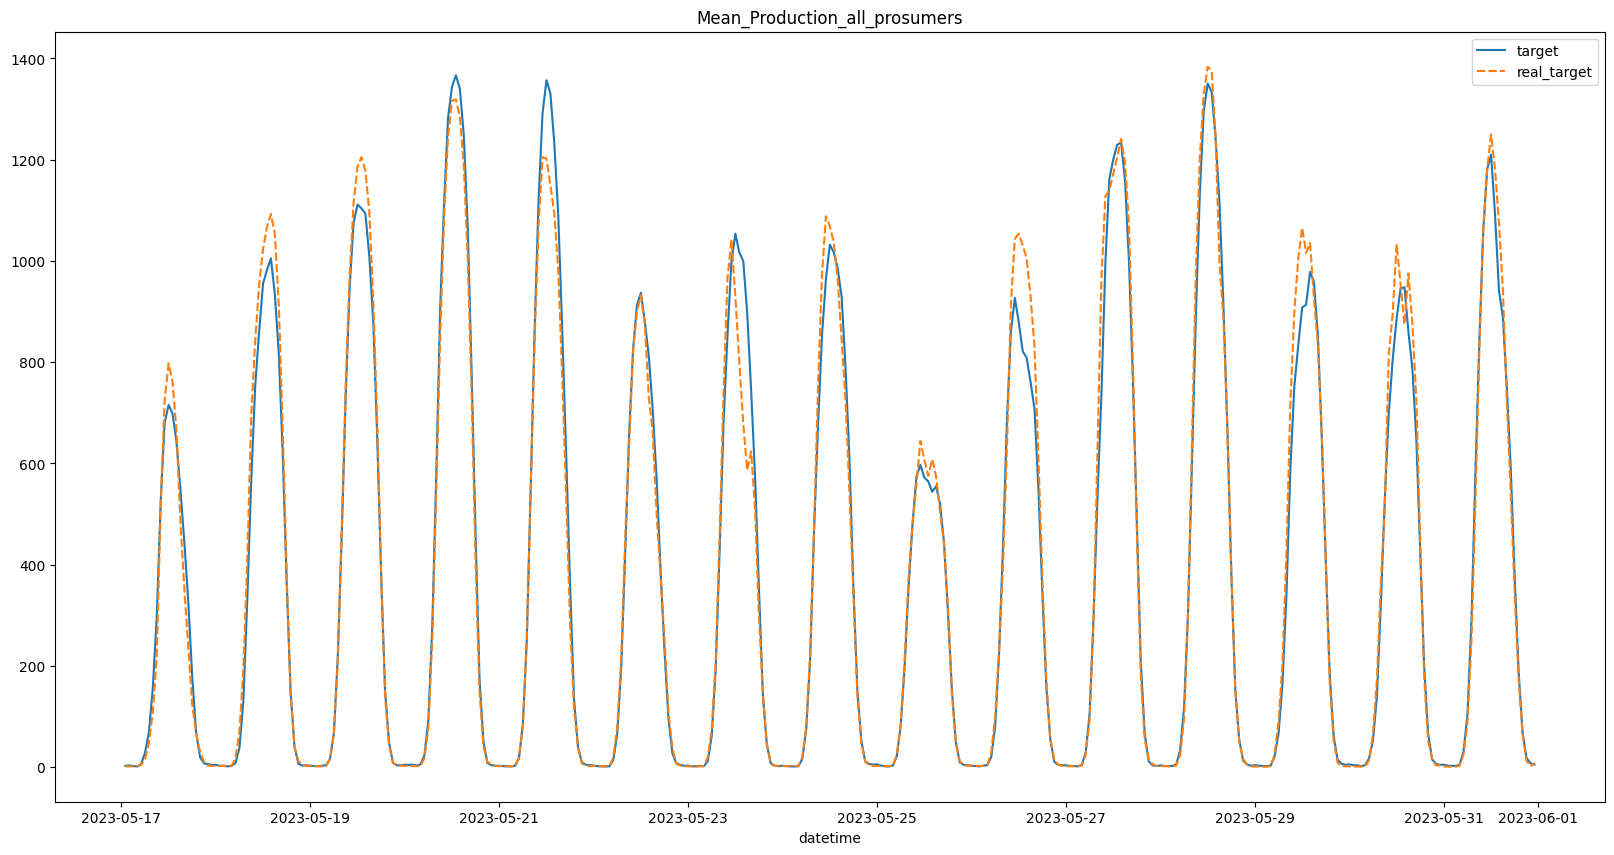

{'model_name': 'catboost', 'MAE': 60.61798755719086}

In [ ]:
calculate_validation_score(model)